# Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

Загружаем датасет и разархивируем

In [1]:
!wget https://www.dropbox.com/s/e120wzgzf34tfqx/archive.zip.. -O archive.zip

--2020-11-30 10:15:03--  https://www.dropbox.com/s/e120wzgzf34tfqx/archive.zip..
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/e120wzgzf34tfqx/archive.zip.. [following]
--2020-11-30 10:15:03--  https://www.dropbox.com/s/raw/e120wzgzf34tfqx/archive.zip..
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbb2fcc802ae0bf5de5f17bc6f6.dl.dropboxusercontent.com/cd/0/inline/BEK7DDc_0u4jxaQDM40zk_5bvZeiR329C71ACzx2NugwLseYRkp9yH1ShiVEj10Wrahjy3tTmVsm2sJrLsnsDNG9I2a1-CiKWx5jy6_DlyC745gfi_HaoUk8znlEiESSBpY/file# [following]
--2020-11-30 10:15:03--  https://ucbb2fcc802ae0bf5de5f17bc6f6.dl.dropboxusercontent.com/cd/0/inline/BEK7DDc_0u4jxaQDM40zk_5bvZeiR329C71ACzx2NugwLseYRkp9yH1ShiVEj10Wrahjy3tTmVsm2sJrLsnsDNG9I2a1-CiKWx5jy6_DlyC745g

In [2]:
! unzip -q  archive.zip

Импортируем всякие модули и посмотрим, что вообще примерно хранится в датасете

In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

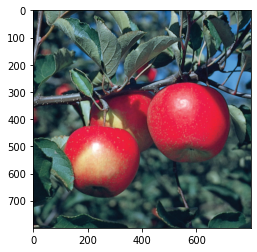

In [ ]:
import glob
import matplotlib.pyplot as plt
file = np.random.choice(glob.glob("./train_zip/train/*.jpg"))
plt.imshow(plt.imread(file))

In [4]:
! pip install xmltodict

Здесь функции для dataloader, train и evaluation

In [5]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import skimage
# add any imports you need

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [6]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """


    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    #площадь dt, gt
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results




def evaluate2(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
      
      for batch, (images, targets) in enumerate(test_loader):

        images =  [image.to(device).float() for image in images]
        targets_pred = model(images)
        targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets]
        targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

        for i in range(len(targets_true)):
          target_true = targets_true[i]
          target_pred = targets_pred[i]
          nbr_boxes += target_true["labels"].shape[0]

          results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)



In [7]:
# def img2tensor(x):
#   return torch.from_numpy(x.transpose(0, 3, 1, 2))

def train_one_epoch(model, train_dataloader, optimizer, epoch, device):
    model.train()
    model = model.to(device).train()
    n = 0
    global_loss = 0
  
    for batch, (images, targets) in enumerate(train_dataloader):
      # images = np.array(images)
      # for i in range(len(images)):
        # images[i] = skimage.img_as_float32(images[i])
      # images = img2tensor(images).to(device).float()
      images =  [image.to(device).float() for image in images]
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      dict_loss = model(images, targets)
      losses = sum(loss for loss in dict_loss.values())

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      n += 1
      global_loss += float(losses.cpu().detach().numpy())
    
      if n % 10 == 0:
        print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))
    PATH = './model2_epoch{}'.format(epoch)
    torch.save(model.state_dict(), PATH)
    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, epoch, device=device)
        model.eval()
        a = evaluate2(model, val_dataloader, device=device)
        print("AUC ON TEST: {:.4f}".format(a), 'epoch: ', epoch)

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

Для аугментации будет использовать пакет albumentations

In [9]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-jmdmnr5s
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-jmdmnr5s
     |████████████████████████████████| 952kB 8.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=72232 sha256=f17b3a4fd47899746242300826f6b1e567d63af02848c138e19e3b882f4ec675
  Stored in directory: /tmp/pip-ephem-wheel-cache-vrbvhuak/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Я добавляю всякие флипы по горизонтали и вертикали, ротацию, изменение контраста яркости с небольшой вероятностью, перевожу все в тензор, боксы храню в формате pascal_voc, потому что так и хранятся ответы по 4 точкам-границам

In [11]:
import albumentations as A
import cv2
from albumentations.pytorch.transforms import ToTensor


#A.Resize(256, 256)
# A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
train_transform = A.Compose([
    A.Rotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.25),
    ToTensor()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),ToTensor()
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['labels']))
# HINT: TRAIN TRANSFORM OBVIOUSLY SHOULD BE HARDER THAN THOSE FOR VALIDATION

# val_transform = A.Compose([ToTensor()])

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)

Беру модель ResNet и буду уже по предобученным весам что-то делать:) 

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4

# Загрузить предобученную сеть -- pretrained=True
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = fasterrcnn_resnet50_fpn(pretrained=True)
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [13]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
train_dataloader2 = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader2 = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [14]:
n_epochs = 10

train(model,train_dataloader2, val_dataloader2, optimizer, device, n_epochs)

Loss value after 10 batches is 0.64
Loss value after 20 batches is 0.54
Loss value after 30 batches is 0.49
Loss value after 40 batches is 0.44
Loss value after 50 batches is 0.42
Loss value after 60 batches is 0.41
Loss value after 70 batches is 0.41
Loss value after 80 batches is 0.41
Loss value after 90 batches is 0.4
Loss value after 100 batches is 0.38
Loss value after 110 batches is 0.37
Loss value after 120 batches is 0.37
AUC ON TEST: 0.6605 epoch:  0
Loss value after 10 batches is 0.35
Loss value after 20 batches is 0.31
Loss value after 30 batches is 0.28
Loss value after 40 batches is 0.29
Loss value after 50 batches is 0.28
Loss value after 60 batches is 0.29
Loss value after 70 batches is 0.28
Loss value after 80 batches is 0.28
Loss value after 90 batches is 0.27
Loss value after 100 batches is 0.27
Loss value after 110 batches is 0.28
Loss value after 120 batches is 0.28
AUC ON TEST: 0.7151 epoch:  1
Loss value after 10 batches is 0.25
Loss value after 20 batches is 0.22

In [15]:
criterion = nn.CrossEntropyLoss()
auc = evaluate2(model, val_dataloader2, device=device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

Оценка за это задание составит 4 баллов


Выведем какой-нибудь примерчик

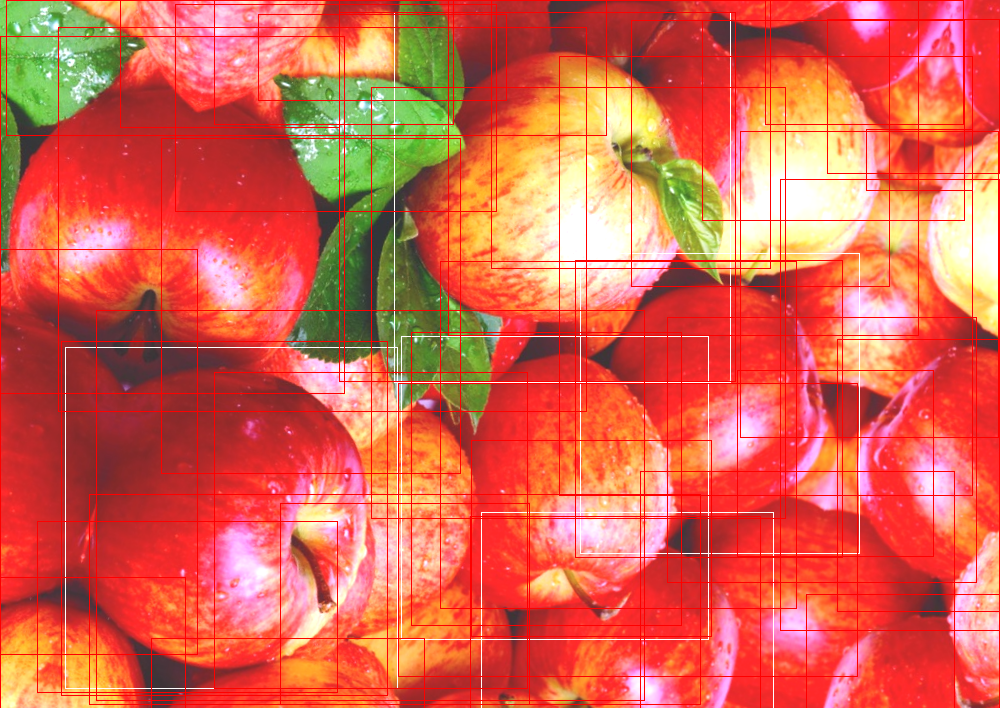

In [25]:
image, labels = val_dataset[1]
pred = model(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image